In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlflow.tracking import MlflowClient
import mlflow

In [2]:
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

In [3]:
def get_experiment_df(experiment_name):
    client = MlflowClient()
    exp_id = client.get_experiment_by_name(experiment_name)

    if exp_id is None:
        return None
    runs_df = mlflow.search_runs(experiment_ids=[exp_id.experiment_id])

    runs_df.columns = [re.sub("params.", "", col) for col in runs_df.columns]
    runs_df.columns = [re.sub("metrics.", "", col) for col in runs_df.columns]
    
    
    return runs_df

## RESULTS FOR 70% OF POOL DATA

In [4]:
experiment_name = "AL_reproducibility"

In [5]:
mlflow_df = get_experiment_df(experiment_name)

In [6]:
coi = ['alc_test','accuracy_baseline','accuracy_test','dataset','query_method_name']
mlflow_df = mlflow_df[coi]

In [7]:
# Step 1: Create a dictionary with random 'alc_test' values for each dataset
random_alc_values = mlflow_df[mlflow_df['query_method_name'] == 'random'].set_index('dataset')['alc_test'].to_dict()

# Step 2: Divide each 'alc_test' by the corresponding 'random' value for each dataset
def divide_by_random(row):
    dataset = row['dataset']
    if dataset in random_alc_values:
        random_value = random_alc_values[dataset]
        if pd.notna(random_value) and pd.notna(row['alc_test']):  # Avoid division by NaN
            return row['alc_test'] / random_value
    return None  # For NaN or missing datasets

# Apply the function to create a new column with the divided values
mlflow_df['alc_ratio'] = mlflow_df.apply(divide_by_random, axis=1)

In [8]:
mlflow_df

,alc_test,accuracy_baseline,accuracy_test,dataset,query_method_name,alc_ratio
0,0.757243,0.777273,0.776623,pima,random,1.000000
1,0.739609,0.799706,0.796176,vehicle,random,1.000000
2,0.961526,0.980247,0.979012,user_knowledge,random,1.000000
3,0.978526,1.000000,1.000000,acute,random,1.000000
4,0.953181,0.964912,0.962281,breast_cancer,random,1.000000
...,...,...,...,...,...,...
66,0.862170,0.880986,0.880986,ionosphere,error_reduction,1.020008
67,0.969381,0.980247,0.978395,user_knowledge,error_reduction,1.008170
68,0.810176,0.844444,0.838889,heart_disease,error_reduction,1.028641
69,NaN,NaN,NaN,None,None,NaN


In [9]:
mlflow_df[mlflow_df[['dataset','query_method_name','alc_test']].duplicated()]

,alc_test,accuracy_baseline,accuracy_test,dataset,query_method_name,alc_ratio
64,NaN,NaN,NaN,None,None,NaN
69,NaN,NaN,NaN,None,None,NaN


In [10]:
alc_df = mlflow_df.pivot_table(index='dataset', columns='query_method_name', values='alc_test', aggfunc='mean')
alc_df = alc_df.reindex(columns=['random','entropy', 'error_reduction', 'max_error_reduction','fivr','max_model_change'])
alc_df.style.apply(highlight_max, axis=1)

query_method_name,random,entropy,error_reduction,max_error_reduction,fivr,max_model_change
dataset,,,,,,
acute,0.978526,0.993942,0.977564,0.969840,0.994038,0.994006
breast_cancer,0.953181,0.960261,nan,0.964398,0.961677,0.960975
diabetes,0.746135,0.742262,0.744898,0.736705,0.752685,0.737247
haberman,0.732735,0.723394,0.725398,0.724268,0.733103,0.717835
heart_disease,0.787618,0.812758,0.810176,0.800342,0.809309,0.813656
ionosphere,0.845257,0.859881,0.862170,0.857077,0.867655,0.813489
parkinsons,0.789378,0.834244,0.818027,0.830302,0.833663,0.840253
pima,0.757243,0.755836,nan,0.738034,0.760555,0.745788
planning,0.602034,0.605757,0.612899,0.604493,0.615142,0.618115


/tmp/ipykernel_29152/1207533061.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)


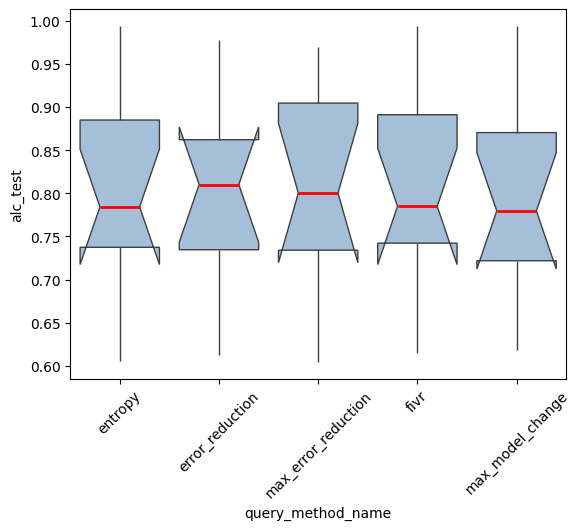

In [11]:
boxplot = sns.boxplot(
    data=mlflow_df, x="query_method_name", y="alc_test",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.3, .5, .7, .5)},
    medianprops={"color": "r", "linewidth": 2},
        order=['entropy', 'error_reduction', 'max_error_reduction','fivr','max_model_change'],
)
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)
plt.show()

In [12]:
means = mlflow_df[mlflow_df.query_method_name!="random"][['query_method_name','alc_ratio']].groupby('query_method_name').mean().reindex(['entropy', 'error_reduction', 'max_error_reduction','fivr','max_model_change'])
means

,alc_ratio
query_method_name,
entropy,1.013341
error_reduction,1.014851
max_error_reduction,1.005470
fivr,1.014706
max_model_change,1.002544


/tmp/ipykernel_29152/1598602178.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)


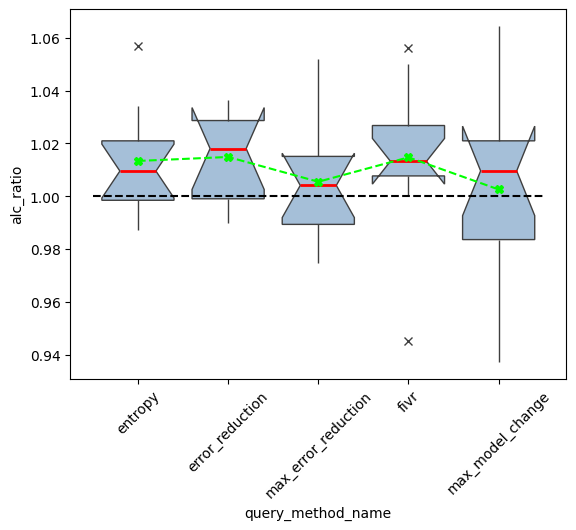

In [13]:
boxplot = sns.boxplot(
    data=mlflow_df[mlflow_df.query_method_name!="random"], x="query_method_name", y="alc_ratio",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.3, .5, .7, .5)},
    medianprops={"color": "r", "linewidth": 2},
    order=['entropy', 'error_reduction', 'max_error_reduction','fivr','max_model_change'],
)


xticks = boxplot.get_xticks()

boxplot.plot([xticks[0]-0.5,xticks[-1]+0.5],[1,1],'k--')
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)
boxplot.plot(xticks,means.values,'X--',color='lime',zorder=5)
plt.show()